# Hafez Ghaemi - 810097013, CA4 Jupyter Notebook, Due Date: Friday, Khordad 1 , AI Course, University of Tehran, School of ECE

In [1]:
# Importing Required Modules
import numpy as np
import copy
import csv
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.feature_selection import mutual_info_classif
from sklearn import preprocessing
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

## 1. Phase 0: Preprocessing

### 1.1. Reading and Cleaning the Data and Interpreting Dates
In this part, the data csv file is stored in a Pandas dataset and the original dataframe is printed. After that, rows with negative Total Quality and Total Price are removed from the dataset. Next, Date column is converted to datetime type and columns of day, month, year, quarter, and weekday are generated. Also, by checking if the weekday is 6 or 7, another column (IsWeekEnd) is created. Furthermore, TemporalProximity is calculated as a measure of how relatively recent the purchase is made. (This relativity is calculated by first differentiating today's date from the date, and then subtracting it from the oldest purchase date in the dataset.). Finally, the first column, Customer ID, and Date are dropped since they are of no use in the learning process.

In [2]:
# Reading the Data and Preprocessing
origDf = pd.read_csv("data.csv")
df = origDf.copy()
df = df[df["Total Quantity"] >= 0 ]
df = df[df["Total Price"] >= 0]
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter
df['weekDay'] = df['Date'].dt.dayofweek
df['IsWeekEnd'] = np.where(df['weekDay'].isin([6,7]),1,0)
df['TemporalProximity'] = (datetime.today() - df['Date']).dt.days
df['TemporalProximity'] -= df['TemporalProximity'].min()
df.drop('Unnamed: 0',axis=1,inplace=True)
df.drop('Customer ID',axis=1,inplace=True)
df.drop('Date',axis=1,inplace=True)

print('Original DF:')
origDf.head()


Original DF:


,Unnamed: 0,Customer ID,Total Quantity,Total Price,Country,Date,Is Back,Purchase Count
0,0,16995,-1,-1.25,United Kingdom,12/2/2010,No,1
1,1,12552,85,13.52,Italy,10/31/2011,Yes,19
2,2,13192,298,15.90,United Kingdom,5/18/2011,Yes,33
3,3,16934,399,8.30,United Kingdom,10/16/2011,No,62
4,4,14976,27,11.90,United Kingdom,1/17/2011,Yes,16


### 1.2. One-Hot Encoding
The first approach for encoding is One-Hot Encoding. This approach creates dummy variables for each label, and the variable is False (0) for all lebels except the real label of each instance that is True (1). This approach is usually used when:
1. The categorical feature is not ordinal. (like countries in this dataset)
2. The number of categorical features is less so one-hot encoding can be effectively applied (In this dataset there are 35 countries which is an acceptable number)

The head of the dataset after one-hot encoding is printed below.

In [3]:
# One-Hot Encoding
oneHotDf = df.copy()
oneHotDf = pd.get_dummies(oneHotDf, columns=['Country'])
print('Preprocessed DF with One-Hot Encoding for Countries: ')
oneHotDf.head()


Preprocessed DF with One-Hot Encoding for Countries: 


,Total Quantity,Total Price,Is Back,Purchase Count,Month,Day,Year,Quarter,weekDay,IsWeekEnd,...,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
1,85,13.52,Yes,19,10,31,2011,4,0,0,...,0,0,0,0,0,0,0,0,0,0
2,298,15.90,Yes,33,5,18,2011,2,2,0,...,0,0,0,0,0,0,0,0,1,0
3,399,8.30,No,62,10,16,2011,4,6,1,...,0,0,0,0,0,0,0,0,1,0
4,27,11.90,Yes,16,1,17,2011,1,0,0,...,0,0,0,0,0,0,0,0,1,0
5,564,204.00,Yes,13,12,12,2010,4,6,1,...,0,0,0,0,0,0,0,0,1,0


### 1.3. Label Encoding
The second approach for encoding is One-Hot Encoding. This approach assigns each label a unique integer. It is normally used when:
1. The categorical feature is ordinal (like Jr. kg, Sr. kg, Primary school, high school)
2. The number of categories is quite large as one-hot encoding can lead to high memory consumption

The head of the dataset after lebel encoding is printed below.

In [4]:
# Label Encoding
leDf = df.copy()
leCountries = preprocessing.LabelEncoder()
leDf['Country'] = leCountries.fit_transform(leDf['Country'])
print('Preprocessed DF with Label Encoding for Countries: ')
leDf.head()

Preprocessed DF with Label Encoding for Countries: 


,Total Quantity,Total Price,Country,Is Back,Purchase Count,Month,Day,Year,Quarter,weekDay,IsWeekEnd,TemporalProximity
1,85,13.52,18,Yes,19,10,31,2011,4,0,0,39
2,298,15.90,35,Yes,33,5,18,2011,2,2,0,205
3,399,8.30,35,No,62,10,16,2011,4,6,1,54
4,27,11.90,35,Yes,16,1,17,2011,1,0,0,326
5,564,204.00,35,Yes,13,12,12,2010,4,6,1,362


In this dataset, since the countries are not ordinal (and we do not want the models to interpret them as ordinal), and the number of label is not too large, one-hot encoding will be used for the learning process.

### 1.3. Scaling the Data
Since scaled data will usually yield a better result in machine learning algorithm, the dataset is scaled using sklearn's StandardScaler. Scaled datasets of both label encoded and one-hot encoded are printed below. But we will use the scaled one-hot encoded dataset for training our models. (It yielded better accuracies, recalls, and precisions.)

In [5]:
# Scaling the Data (for Label Encoding)
DfColumns = list(leDf.columns)
DfColumns.remove('Is Back')
ss = StandardScaler()
leDf[DfColumns] = ss.fit_transform(leDf.drop('Is Back',axis=1))
leDf.head()


,Total Quantity,Total Price,Country,Is Back,Purchase Count,Month,Day,Year,Quarter,weekDay,IsWeekEnd,TemporalProximity
1,-0.377948,-0.036228,-2.473303,Yes,-0.226948,0.765147,1.988744,0.499477,1.120965,-1.409191,-0.386021,-1.543188
2,0.099472,-0.034247,0.291084,Yes,0.373487,-0.496836,0.470925,0.499477,-0.487769,-0.314112,-0.386021,-0.136370
3,0.325854,-0.040573,0.291084,No,1.617245,0.765147,0.237415,0.499477,1.120965,1.876044,2.590534,-1.416066
4,-0.507949,-0.037577,0.291084,Yes,-0.355613,-1.506422,0.354170,0.499477,-1.292135,-1.409191,-0.386021,0.889081
5,0.695686,0.122314,0.291084,Yes,-0.484277,1.269940,-0.229607,-2.002092,1.120965,1.876044,2.590534,1.194174


In [6]:
# Scaling the Data (for One-Hot Encoding)
DfColumns = list(oneHotDf.columns)
DfColumns.remove('Is Back')
ss = StandardScaler()
oneHotDf[DfColumns] = ss.fit_transform(oneHotDf.drop('Is Back',axis=1))
oneHotDf.head()

,Total Quantity,Total Price,Is Back,Purchase Count,Month,Day,Year,Quarter,weekDay,IsWeekEnd,...,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
1,-0.377948,-0.036228,Yes,-0.226948,0.765147,1.988744,0.499477,1.120965,-1.409191,-0.386021,...,-0.015456,-0.015456,-0.015456,-0.082051,-0.040922,-0.067517,-0.030923,-0.021861,-3.072686,-0.030923
2,0.099472,-0.034247,Yes,0.373487,-0.496836,0.470925,0.499477,-0.487769,-0.314112,-0.386021,...,-0.015456,-0.015456,-0.015456,-0.082051,-0.040922,-0.067517,-0.030923,-0.021861,0.325448,-0.030923
3,0.325854,-0.040573,No,1.617245,0.765147,0.237415,0.499477,1.120965,1.876044,2.590534,...,-0.015456,-0.015456,-0.015456,-0.082051,-0.040922,-0.067517,-0.030923,-0.021861,0.325448,-0.030923
4,-0.507949,-0.037577,Yes,-0.355613,-1.506422,0.354170,0.499477,-1.292135,-1.409191,-0.386021,...,-0.015456,-0.015456,-0.015456,-0.082051,-0.040922,-0.067517,-0.030923,-0.021861,0.325448,-0.030923
5,0.695686,0.122314,Yes,-0.484277,1.269940,-0.229607,-2.002092,1.120965,1.876044,2.590534,...,-0.015456,-0.015456,-0.015456,-0.082051,-0.040922,-0.067517,-0.030923,-0.021861,0.325448,-0.030923


### 1.4. Information Gain Calculation
Using sklearns' mutual_info_classif and assuming that all features are discrete, information gain for both one-hot encoded and label encoded datasets are calculated. 
The results show that that Total Quantity, Total Price, Month, and Temporal Proximity have the highest information gain which is justified by the behavior of people in real life. For example, customers who have purchased more from a business will be more likely to be back, or customers who purchase in a regular month (not holidays) are more likely to be regular customers.

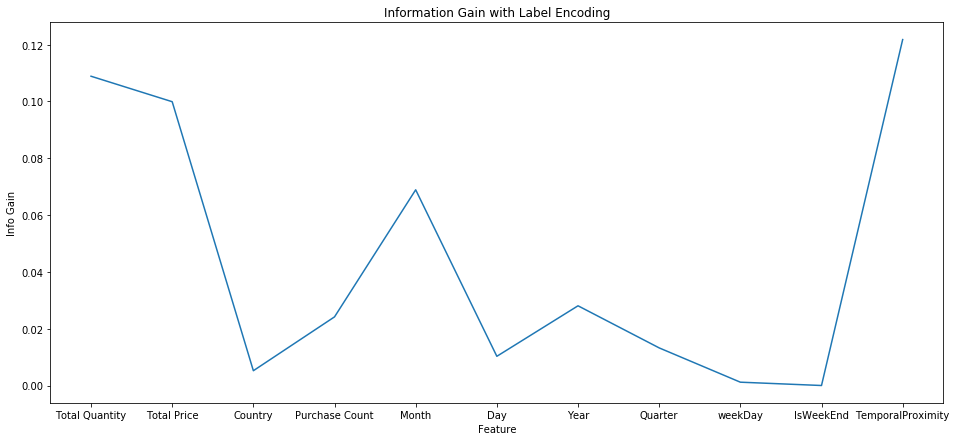

In [7]:
# Information Gain Calculation
columns = list(leDf.columns)
columns.remove('Is Back')
#print(columns)
X = leDf[columns].values
y = leDf['Is Back'].values
#print(columns)
leDfIG = dict(zip(columns, mutual_info_classif(X, y, discrete_features=True)))
plt.figure(figsize=(16,7))
plt.plot(list(leDfIG.keys()),list(leDfIG.values()))
plt.ylabel('Info Gain')
plt.xlabel('Feature')
plt.title('Information Gain with Label Encoding')
plt.show()

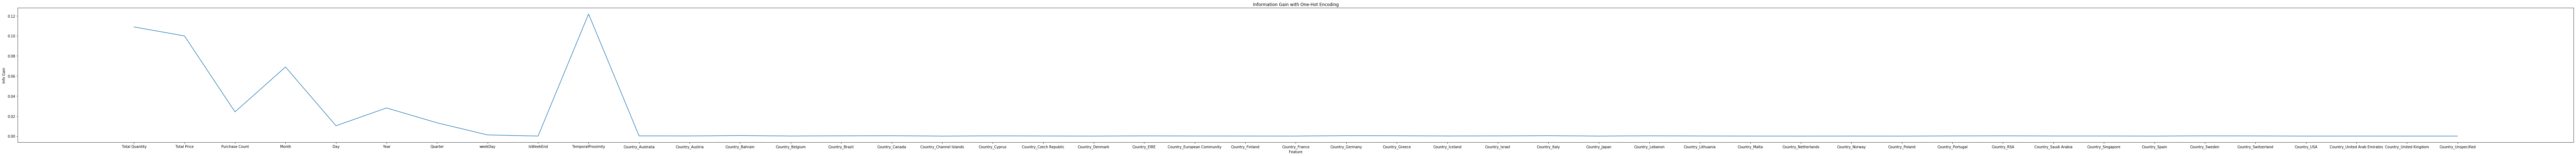

In [8]:
# Information Gain Calculation (with One-Hot Encoding)
columns = list(oneHotDf.columns)
columns.remove('Is Back')
X = oneHotDf[columns].values
y = oneHotDf['Is Back'].values
leDfIG = dict(zip(columns, mutual_info_classif(X, y, discrete_features=True)))
plt.figure(figsize=(130,7))
plt.plot(list(leDfIG.keys()),list(leDfIG.values()))
plt.ylabel('Info Gain')
plt.xlabel('Feature')
plt.title('Information Gain with One-Hot Encoding')
plt.show()

## 2. Phase 1. Individual Model Training

### 2.1. Train-Test Split
The data is splitted into train and test datasets using sklearn's train_test_split. The size of the test set is 0.2 of the whole dataset. (Pareto Principle)

In [9]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(oneHotDf.drop('Is Back',axis=1), oneHotDf['Is Back'],\
                                                    test_size=0.2, random_state=42)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (3349, 47) (3349,)
Test set: (838, 47) (838,)


### 2.2. Decision Tree Classifier
Decision tree is trained with entropy criterion and using max_depth for the hyperparameter. The hyperparameter is tuned by exhaustively changing it from 1 to 35. As expected, the train set accuracy reaches 1 as we deepen the tree. (due to overfitting) The best depth had the best test set accuracy and in this case is 6. The classification report (with the optimum depth) and the acc-depth plot is given below. The only unacceptable result is the label 'NO' recall which is below 50 percent.

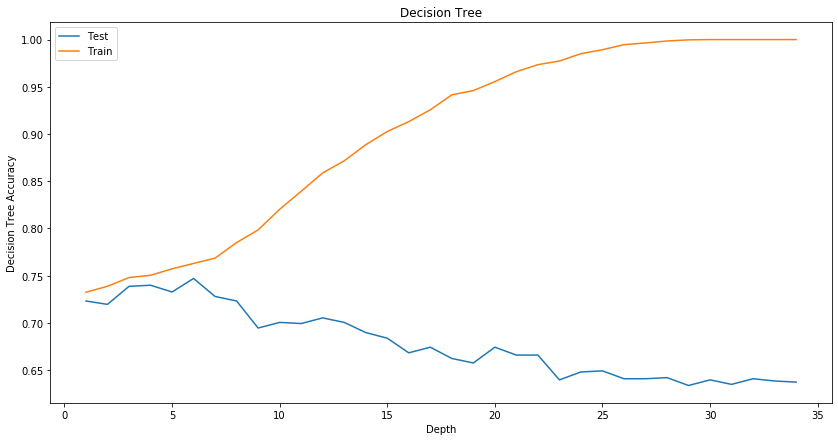

Results for Optimum Depth, 6 :
Train Set Classification Report:
              precision    recall  f1-score   support

          No       0.70      0.44      0.54      1069
         Yes       0.78      0.91      0.84      2280

    accuracy                           0.76      3349
   macro avg       0.74      0.68      0.69      3349
weighted avg       0.75      0.76      0.75      3349

Test Set Classification Report:
              precision    recall  f1-score   support

          No       0.68      0.43      0.53       276
         Yes       0.76      0.90      0.83       562

    accuracy                           0.75       838
   macro avg       0.72      0.67      0.68       838
weighted avg       0.74      0.75      0.73       838



In [10]:
# Decision Tree
depths = list()
accs = list()
depths_train = list()
accs_train = list()
for i in range(1, 35):
    decTree = tree.DecisionTreeClassifier(criterion="entropy", max_depth = i)
    decTree.fit(X_train, y_train)
    y_pred = decTree.predict(X_test)
    y_pred_train = decTree.predict(X_train)
    accs.append(metrics.accuracy_score(y_test, y_pred))
    depths.append(i)
    accs_train.append(metrics.accuracy_score(y_train, y_pred_train))
    depths_train.append(i)
plt.figure(figsize=(14,7))
plt.plot(depths,accs, label = 'Test')
plt.plot(depths_train,accs_train, label='Train')
plt.ylabel('Decision Tree Accuracy')
plt.xlabel('Depth')
plt.title('Decision Tree')
plt.legend()
plt.show()

optDepth = depths[accs.index(max(accs))]
decTree = tree.DecisionTreeClassifier(criterion="entropy", max_depth = optDepth)
decTree.fit(X_train, y_train)
y_pred = decTree.predict(X_test)
y_pred_train = decTree.predict(X_train)
DT_acc = metrics.accuracy_score(y_test, y_pred)
DT_acc_train = metrics.accuracy_score(y_train, y_pred_train)
print('Results for Optimum Depth,', optDepth,':')
print('Train Set Classification Report:')
print(classification_report(y_train, y_pred_train))
print('Test Set Classification Report:')
print(classification_report(y_test, y_pred))

### 2.2. KNN Classifier
KNN is trained with n_neighbors as the hyperparameter. The hyperparameter is tuned by exhaustively changing it from 1 to 30. As expected, the train set accuracy is near 1 when k is small. (due to overfitting) The best k had the best test set accuracy and in this case is 24. The classification report (with the optimum k) and the acc-k plot is given below. The only unacceptable result is the label 'NO' recall which is below 50 percent.

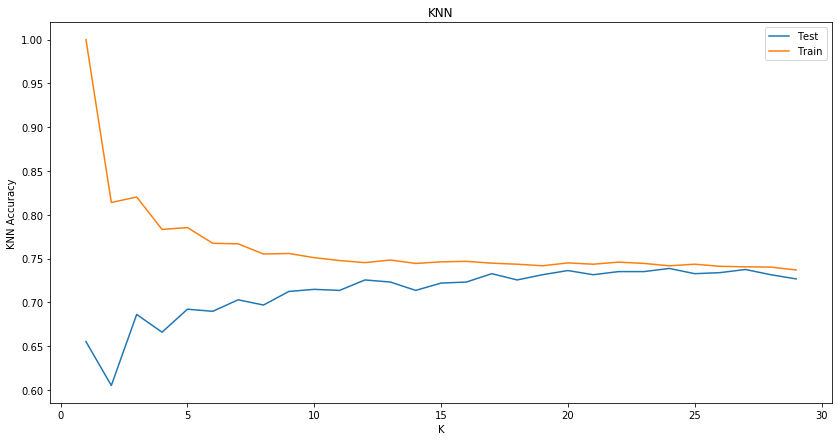

Results for Optimum K, 24 :
Train Set Classification Report:
              precision    recall  f1-score   support

          No       0.65      0.41      0.50      1069
         Yes       0.76      0.90      0.83      2280

    accuracy                           0.74      3349
   macro avg       0.71      0.65      0.66      3349
weighted avg       0.73      0.74      0.72      3349

Test Set Classification Report:
              precision    recall  f1-score   support

          No       0.65      0.45      0.53       276
         Yes       0.76      0.88      0.82       562

    accuracy                           0.74       838
   macro avg       0.71      0.66      0.67       838
weighted avg       0.73      0.74      0.72       838



In [11]:
# KNN
depths = list()
accs = list()
depths_train = list()
accs_train = list()
for i in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    y_pred_train = knn.predict(X_train)
    accs.append(metrics.accuracy_score(y_test, y_pred))
    depths.append(i)
    accs_train.append(metrics.accuracy_score(y_train, y_pred_train))
    depths_train.append(i)
plt.figure(figsize=(14,7))
plt.plot(depths,accs, label='Test')
plt.plot(depths_train,accs_train, label='Train')
plt.title('KNN')
plt.ylabel('KNN Accuracy')
plt.xlabel('K')
plt.legend()
plt.show()

optK = depths[accs.index(max(accs))]
print('Results for Optimum K,', optK,':')
knn = KNeighborsClassifier(n_neighbors = optK).fit(X_train,y_train)
y_pred = knn.predict(X_test)
y_pred_train = knn.predict(X_train)
knn_acc = metrics.accuracy_score(y_test, y_pred)
knn_acc_train = metrics.accuracy_score(y_train, y_pred_train)
print('Train Set Classification Report:')
print(classification_report(y_train, y_pred_train))
print('Test Set Classification Report:')
print(classification_report(y_test, y_pred))

### 2.2. Logistic Regression Classifier
Logistice Regression Classifier is trained with C=0.01 and liblinear solver. The classification report is given below. The only unacceptable results are the label 'NO' precision and recall.

In [12]:
# Logistic Regression
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
y_pred = LR.predict(X_test)
y_pred_train = LR.predict(X_train)
LR_acc = metrics.accuracy_score(y_test, y_pred)
LR_acc_train = metrics.accuracy_score(y_train, y_pred_train)
print('Train Set Classification Report:')
print(classification_report(y_train, y_pred_train))
print('Test Set Classification Report:')
print(classification_report(y_test, y_pred))

Train Set Classification Report:
              precision    recall  f1-score   support

          No       0.62      0.48      0.54      1069
         Yes       0.78      0.86      0.82      2280

    accuracy                           0.74      3349
   macro avg       0.70      0.67      0.68      3349
weighted avg       0.73      0.74      0.73      3349

Test Set Classification Report:
              precision    recall  f1-score   support

          No       0.62      0.47      0.54       276
         Yes       0.77      0.86      0.81       562

    accuracy                           0.73       838
   macro avg       0.69      0.67      0.67       838
weighted avg       0.72      0.73      0.72       838



## 3. Phase 2: Model Aggregation

### 3.1. Decision Tree Bagging
Bagging is done using sklearn's BaggingClassifier. The optimum tree from the individual decision tree model (with optimum depth) is assigned as the base_estimator. max_features and max_samples are assigned as 0.5. Also, 20 is assigned as the number of estimators. (More than this number of estimators did not affect the results.) The classification report is given below. Just like the individual models the label 'NO' recall is again below 50 percent.

In [13]:
# Bagging with Decision Tree
baggingDT = BaggingClassifier(base_estimator = tree.DecisionTreeClassifier(max_depth = optDepth),\
                            max_features=0.5, max_samples=0.5, n_estimators=20, random_state=42).fit(X_train, y_train)
y_pred = baggingDT.predict(X_test)
y_pred_train = baggingDT.predict(X_train)
baggingDT_acc = metrics.accuracy_score(y_test, y_pred)
baggingDT_acc_train = metrics.accuracy_score(y_train, y_pred_train)
print('Train Set Classification Report:')
print(classification_report(y_train, y_pred_train))
print('Test Set Classification Report:')
print(classification_report(y_test, y_pred))

Train Set Classification Report:
              precision    recall  f1-score   support

          No       0.73      0.39      0.51      1069
         Yes       0.77      0.93      0.84      2280

    accuracy                           0.76      3349
   macro avg       0.75      0.66      0.68      3349
weighted avg       0.75      0.76      0.74      3349

Test Set Classification Report:
              precision    recall  f1-score   support

          No       0.70      0.36      0.47       276
         Yes       0.75      0.93      0.83       562

    accuracy                           0.74       838
   macro avg       0.72      0.64      0.65       838
weighted avg       0.73      0.74      0.71       838



### 3.2. KNN Bagging
Bagging is done using sklearn's BaggingClassifier. The optimum knn classifier from the individual decision KNN model (with optimum k) is assigned as the base_estimator. max_features and max_samples are assigned as 0.5. Also, 20 is assigned as the number of estimators. (More than this number of estimators did not affect the results.) The classification report is given below. Just like the individual models the label 'NO' recall is again below 50 percent.

In [14]:
# Bagging with KNN
baggingKNN = BaggingClassifier(base_estimator = KNeighborsClassifier(n_neighbors = optK),\
                            max_features=0.5, max_samples=0.5, n_estimators=20, random_state=42).fit(X_train, y_train)
y_pred = baggingKNN.predict(X_test)
y_pred_train = baggingKNN.predict(X_train)
baggingKNN_acc = metrics.accuracy_score(y_test, y_pred)
baggingKNN_acc_train = metrics.accuracy_score(y_train, y_pred_train)
print('Train Set Classification Report:')
print(classification_report(y_train, y_pred_train))
print('Test Set Classification Report:')
print(classification_report(y_test, y_pred))

Train Set Classification Report:
              precision    recall  f1-score   support

          No       0.69      0.34      0.46      1069
         Yes       0.75      0.93      0.83      2280

    accuracy                           0.74      3349
   macro avg       0.72      0.64      0.64      3349
weighted avg       0.73      0.74      0.71      3349

Test Set Classification Report:
              precision    recall  f1-score   support

          No       0.71      0.36      0.48       276
         Yes       0.75      0.93      0.83       562

    accuracy                           0.74       838
   macro avg       0.73      0.64      0.65       838
weighted avg       0.73      0.74      0.71       838



### 3.3. Random Forest
Decision Tree Random Forest is implemented using n_setimators and max_depth as hyperparameters. The hyper parameters are tuned exhaustively and the optimum max depth 6 and n_estimators 12 are obtained. The results and depth-acc and n_estimators-acc plots are given below. As expected the accuracy of the RF model is slightly better than the individula and bagging models. However, the problem with the label 'NO' recall is still present.


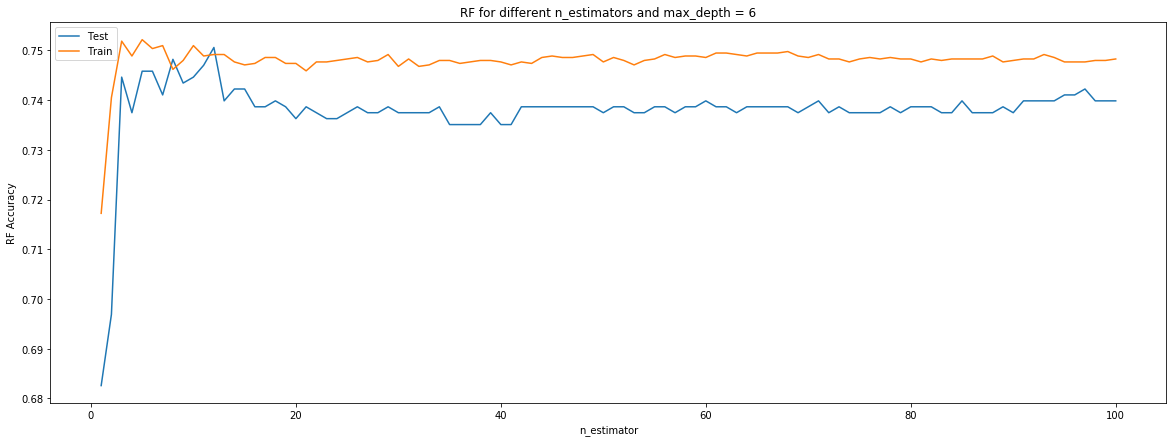

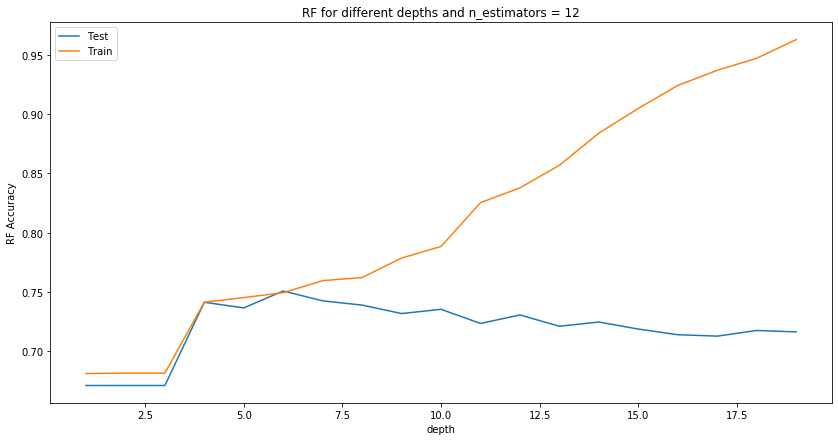

Results for Optimum max_depth, 6 and Optimum n_estimators, 12 :
Train Set Classification Report:
              precision    recall  f1-score   support

          No       0.72      0.35      0.47      1069
         Yes       0.75      0.94      0.84      2280

    accuracy                           0.75      3349
   macro avg       0.74      0.64      0.65      3349
weighted avg       0.74      0.75      0.72      3349

Test Set Classification Report:
              precision    recall  f1-score   support

          No       0.75      0.37      0.49       276
         Yes       0.75      0.94      0.83       562

    accuracy                           0.75       838
   macro avg       0.75      0.65      0.66       838
weighted avg       0.75      0.75      0.72       838



In [15]:
# Random Forest
depths = list()
nEstimators = list()
accs = list()
accs_train = list()
for i in range(1, 101):
    RF = RandomForestClassifier(n_estimators=i, max_depth=6, random_state=42)
    RF.fit(X_train, y_train)
    y_pred = RF.predict(X_test)
    y_pred_train = RF.predict(X_train)
    accs.append(metrics.accuracy_score(y_test, y_pred))
    nEstimators.append(i)
    accs_train.append(metrics.accuracy_score(y_train, y_pred_train))

optNEstimators = nEstimators[accs.index(max(accs))]

plt.figure(figsize=(20,7))
plt.plot(nEstimators,accs, label='Test')
plt.plot(nEstimators,accs_train, label='Train')
plt.title('RF for different n_estimators and max_depth = 6')
plt.ylabel('RF Accuracy')
plt.xlabel('n_estimator')
plt.legend()
plt.show()

accs = list()
accs_train = list()
for i in range(1, 20):
    RF = RandomForestClassifier(n_estimators=optNEstimators, max_depth=i, random_state=42)
    RF.fit(X_train, y_train)
    y_pred = RF.predict(X_test)
    y_pred_train = RF.predict(X_train)
    accs.append(metrics.accuracy_score(y_test, y_pred))
    depths.append(i)
    accs_train.append(metrics.accuracy_score(y_train, y_pred_train))

optDepth = depths[accs.index(max(accs))]

plt.figure(figsize=(14,7))
plt.plot(depths,accs, label='Test')
plt.plot(depths,accs_train, label='Train')
plt.title('RF for different depths and n_estimators = 12')
plt.ylabel('RF Accuracy')
plt.xlabel('depth')
plt.legend()
plt.show()

RF = RandomForestClassifier(n_estimators=optNEstimators, max_depth=optDepth, random_state=42)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)
y_pred_train = RF.predict(X_train)
RF_acc = metrics.accuracy_score(y_test, y_pred)
RF_acc_train = metrics.accuracy_score(y_train, y_pred_train)
print('Results for Optimum max_depth,', optDepth, 'and Optimum n_estimators,', optNEstimators,':')
print('Train Set Classification Report:')
print(classification_report(y_train, y_pred_train))
print('Test Set Classification Report:')
print(classification_report(y_test, y_pred))

### 3.4. Bagging Effect on Overfiting
To test the bagging effect on overfitting, an overfit method (KNN with k=1 that has a 1.00 accuracy on the train set and a low accuracy on the test set) is given as the base_estimator of the bagging method. However bagging has almost eliminated the result of the overfit base_estimator and the accuracy has increased. The results of both the bagging method and the overfit method are given below.

In [16]:
# Bagging Effect on Ovefitting (KNN with k = 1)
baggingKNNOF = BaggingClassifier(base_estimator = KNeighborsClassifier(n_neighbors = 1),\
                            max_features=0.5, max_samples=0.5, n_estimators=15, random_state=42).fit(X_train, y_train)
y_pred = baggingKNNOF.predict(X_test)
y_pred_train = baggingKNNOF.predict(X_train)
print('Bagging with KNN (k=1) as best_estimator:')
print('Train Set Classification Report:')
print(classification_report(y_train, y_pred_train))
print('Test Set Classification Report:')
print(classification_report(y_test, y_pred))
# Normal KNN with k = 1
knn = KNeighborsClassifier(n_neighbors = 1).fit(X_train,y_train)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_pred_train = knn.predict(X_train)
print('Simple KNN with k=1:')
print('Train Set Classification Report:')
print(classification_report(y_train, y_pred_train))
print('Test Set Classification Report:')
print(classification_report(y_test, y_pred))

Bagging with KNN (k=1) as best_estimator:
Train Set Classification Report:
              precision    recall  f1-score   support

          No       0.92      0.73      0.81      1069
         Yes       0.88      0.97      0.93      2280

    accuracy                           0.89      3349
   macro avg       0.90      0.85      0.87      3349
weighted avg       0.90      0.89      0.89      3349

Test Set Classification Report:
              precision    recall  f1-score   support

          No       0.60      0.36      0.45       276
         Yes       0.74      0.88      0.80       562

    accuracy                           0.71       838
   macro avg       0.67      0.62      0.63       838
weighted avg       0.69      0.71      0.69       838

Simple KNN with k=1:
Train Set Classification Report:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00      1069
         Yes       1.00      1.00      1.00      2280

    accuracy         

### 3.5. Bootstrapping
Bootstrapping is a technique used to iteratively improve a classifier's performance. Typically, multiple classifiers will be trained on different sets (samples) of the input data, and on prediction tasks the output of the different classifiers will be combined together. Bagging (Bootstrap Aggregation) is a bootstrapping method. In bagging, a certain number of equally sized subsets of a dataset are extracted with replacement. Then, a machine learning algorithm is applied to each of these subsets and the outputs are ensembled. There is a bias-variance trade off in bootstrapping methods. If many samples are used the bias is reduced. However using many samples can increase variance. The task of a model developer is to choose the number of samples to make this trade-off acceptable.

### 3.6. Hard-Voting Classifier
The hard-voting classifier is implemented using the decTree, KNN, and LR models from phase 1 of the project. The results are given below. The problem with the label 'NO' recall and precision is still present.

In [17]:
# Hard-Voting Classifier
VC = VotingClassifier(estimators=[('lr', LR), ('knn', knn), ('dt', decTree)], voting='hard')
VC.fit(X_train, y_train)
y_pred = VC.predict(X_test)
y_pred_train = VC.predict(X_train)
VC_acc = metrics.accuracy_score(y_test, y_pred)
VC_acc_train = metrics.accuracy_score(y_train, y_pred_train)
print('Train Set Classification Report:')
print(classification_report(y_train, y_pred_train))
print('Test Set Classification Report:')
print(classification_report(y_test, y_pred))

Train Set Classification Report:
              precision    recall  f1-score   support

          No       0.75      0.52      0.61      1069
         Yes       0.80      0.92      0.86      2280

    accuracy                           0.79      3349
   macro avg       0.78      0.72      0.74      3349
weighted avg       0.79      0.79      0.78      3349

Test Set Classification Report:
              precision    recall  f1-score   support

          No       0.66      0.44      0.53       276
         Yes       0.76      0.89      0.82       562

    accuracy                           0.74       838
   macro avg       0.71      0.66      0.67       838
weighted avg       0.73      0.74      0.72       838



### 3.7. Models Comparison
First of all the accuracy of all trained models for both test set and train set are plotted below. As we can see the Random Forest model has the best test set accuracy. The failure of the voting classifier method (which was expected to be the most accurate model) can be explained by calculating the similarities between the individual models.

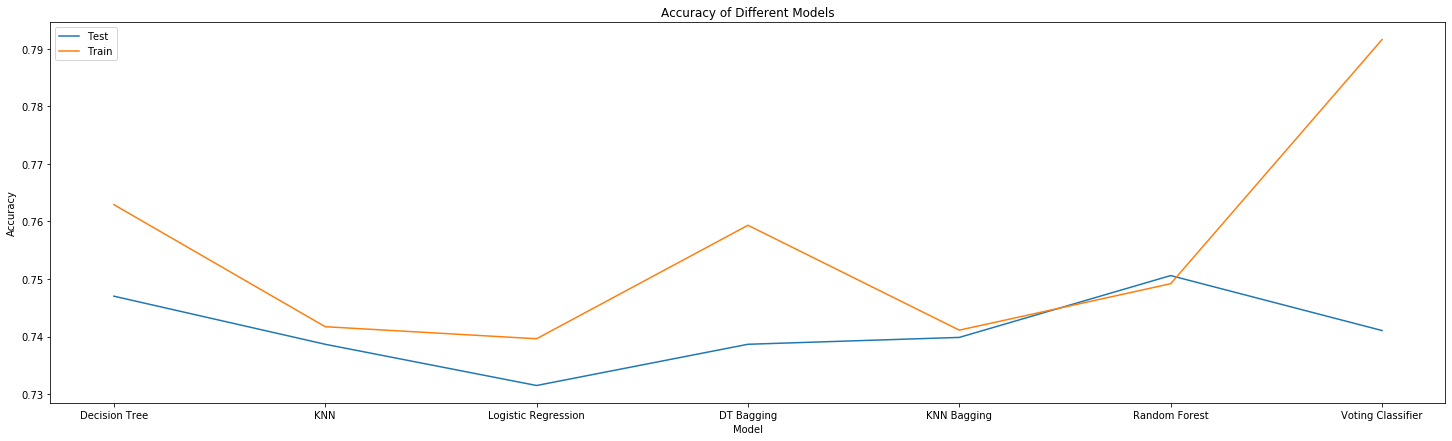

In [18]:
# Models Comparison
models = ['Decision Tree', 'KNN', 'Logistic Regression', 'DT Bagging', 'KNN Bagging', 'Random Forest', 'Voting Classifier']
accs = [DT_acc, knn_acc, LR_acc, baggingDT_acc, baggingKNN_acc, RF_acc, VC_acc]
accs_train = [DT_acc_train, knn_acc_train, LR_acc_train, baggingDT_acc_train, baggingKNN_acc_train, RF_acc_train, VC_acc_train]
plt.figure(figsize=(25,7))
plt.plot(models,accs, label='Test')
plt.plot(models,accs_train, label='Train')
plt.title('Accuracy of Different Models')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.legend()
plt.show()

### Models Similarities
In the following block, the similarities between individual decTree, KNN, and LR models are computed. As we can see these models' predictions are 72% similar. Therefor, hard-voting between them cannot increase the accuracy substantially. This is the reason for the failure of the hard-voting classifier trained above.

In [19]:
# Models Similarities
y_pred_dt = decTree.predict(X_test)
y_pred_train_dt = decTree.predict(X_train)
y_pred_knn = knn.predict(X_test)
y_pred_train_knn = knn.predict(X_train)
y_pred_lr = LR.predict(X_test)
y_pred_train_lr = LR.predict(X_train)
sims = 0.0
for i in range(len(y_pred_dt)):
    if y_pred_dt[i] == y_pred_knn[i] and y_pred_dt[i] == y_pred_lr[i]:
        sims += 1
simPercentage = sims/len(y_pred_dt)
print('DecTree, KNN, and LR models predictions are', simPercentage, 'percent similar.')

DecTree, KNN, and LR models predictions are 0.7219570405727923 percent similar.


## 4. Conclusion
The best result was achived using the Random Forset Classifier. However, even for this model the recall for label 'NO' was way below the acceptable threshold. (The other criteria can be accepted.) This result may be attributed to the data. Perhaps, if a richer dataset were available, we could achieve much better results.